# CSCI 3022 Final Project: STEM Salary Analysis

## Project Description

The goal of ths project is two fold:
 - produce a model to predict annual income for employees in STEM fields using regression
 - identify which factors are the most influential in predicting annual income

There are many reasons why understanding what influence salary is important.  One of the most important decisions a person makes in their lifetime is choosing a career.  A major motivation for people in choosing a career is income.  Being able to determine your earning potential is in important part in the decision making processing.  Additionally, knowing your market worth is also an important part of negotiating starting salary, raises and determining if/when to look for a new job or make a career change.

## Add more detailed project motivation

## Data Source

The data used for this project comes from the following source:

https://www.kaggle.com/jackogozaly/data-science-and-stem-salaries

The data contains 29 columns and 62,642 rows of data.  The data contains annual compensation information, job location, employee information including gender, race, education level, years of experience and years at the company.  

The dependent variable the regression will attempt to predict is the column totalyearlycompensation (renamed to totalcomp).  

At the start of the analysis the following columns were removed:
 - timestamp: This column includes the date and time the data was recorded and spans approximately a 4 year period from 2017 to 2021.  Because this is a relative short period of time it is assumed that no significant wage growth occured and therefore this does not have a significant impact on the dependent variable.
 - rowNumber: This is an integer value representing the row number and does not relate to the dependent variable.
 - level: This represents the level within a company that typically corresponds to an employees wage bracket.  While this is very likely to correlate strongly with an employees compensation, each company has it's own coding system to represent these levels.  Because of this there are 2929 unique values in this column with no clear way to standardize them between all the companies.  Furthermore, the level of an employee is typically determined by level of education and years of experience, both of which will be included in this analysis so it is assumed that little if any value could be obtained from this column.
 - tag: This column contains 3058 unique values, including a variety of skills and job description terms and acronyms.  Due to the number of unique values and type of data it is not considered relevant to the analysis.
 - otherdetails: This column contains 12,841 unique values including job descriptions, bonuses, working arrangements and 22,504 null values.  Due to the number of unique and null values and type of data it is not considered relevant to the analysis.
 - location: This column contains a string represening the city the job is located in.  The cityid captures the same data but with an interger representing the city, therefore this column is not necessary.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})
import patsy
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import datasets,linear_model,metrics
from sklearn.model_selection import cross_val_predict, cross_val_score

raw_data = pd.read_csv('Levels_Fyi_Salary_Data.csv')

In [2]:
data = raw_data.copy()

# Drop unnecessary rows
data = data.drop(['timestamp', 'level', 'rowNumber', 'tag', 'otherdetails', 'Masters_Degree', 
                 'Bachelors_Degree', 'Doctorate_Degree', 'Highschool', 'Some_College', 
                 'Race_Asian', 'Race_White', 'Race_Two_Or_More', 'Race_Black', 
                  'Race_Hispanic'], axis=1)

# Rename columns
data = data.rename(columns={'totalyearlycompensation': 'totalcomp', 
                            'yearsofexperience': 'experience', 
                            'Education': 'education', 
                            'Race': 'race'})

# Update column data types
data[data.select_dtypes(['object']).columns] = data.select_dtypes(['object']).apply(lambda x: x.astype('category'))
data = data.dropna(subset=['dmaid'], axis='rows') # drop 2 rows where dmaid is null
data[data.select_dtypes(['float64']).columns] = data.select_dtypes(['float64']).apply(lambda x: x.astype('int32'))


## Data Cleaning and Visualization

### Dependent Variable

The dependent variable totalcomp is expected to strongly correlate to the other compensation variables: basesalary, stockgrantvalue and bonus.  While there may be other forms of compensations employees receive, such as retirement and health benefits, these generally do not make up a substantial portion of an employees compensation.  Reviewing the compensation variables and comparing them to the totalcomp there appears to be a couple of issues with the data:
 - There are 2297 rows for which there are values of 0 for the basesalary, stockgrantvalue and bonus and another 7 values for which there is a value for 0 for basesalary.  This is believed to be an error since most employees receive a base salary.  All 2304 values are considedered to be either errors or outliers and their rows are removed.
 - There are 5993 rows for which there the totalcomp is less than the sum of the basesalary, stockgrantvalue and bonus.  These are rows are removed, since this indicates there is an error in at least one of the four columns.

In [3]:
# Remove likely errors

data = data.drop(data.loc[data.basesalary==0].index)
data['compdifference'] = data.totalcomp - data.basesalary + data.stockgrantvalue + data.bonus
data = data.drop(data.loc[data.compdifference < 0.].index)
data = data.drop(['compdifference'], axis=1)

#### Total Yearly Compensation

Review of a historgram of the totalcomp data shows that data has an extreme right skew likely from outliers.  The top 0.5% of values were removed.

In [4]:
# Creates side by side histograms of original data & data with upper limit remove
def compare_hist(col, title, limit, bin):
    fig,ax = plt.subplots(nrows=1, ncols=2, sharey=False,figsize=(10,4))
    plt.title(title)
    ax[0].hist(col, bins=bin)
    ax[0].set_xlabel('Original')
    ax[1].hist(col[col < limit], bins=bin)
    ax[1].set_xlabel('Reduced');

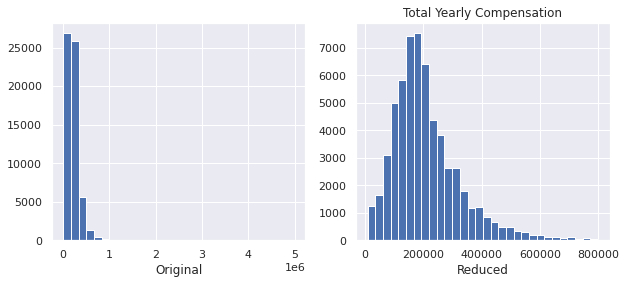

In [5]:
comp_cu = np.percentile(data.totalcomp, 99.5)

compare_hist(data.totalcomp, 'Total Yearly Compensation', comp_cu, 30)

In [6]:
data = data.drop(data.loc[data.totalcomp > comp_cu].index)

#### Base Salary

Review of a historgram of the basesalary data shows that data has an extreme right skew likely from outliers.  The top 0.5% of values were removed.

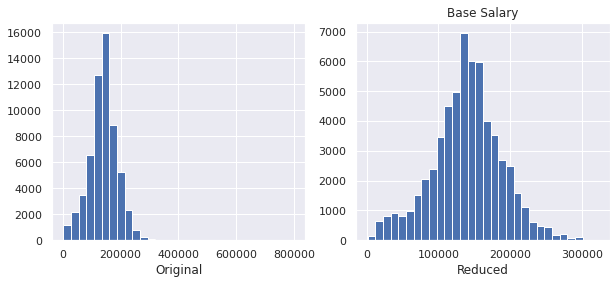

In [7]:
salary_cu = np.percentile(data.basesalary, 99.5)

compare_hist(data.basesalary, 'Base Salary', salary_cu, 30)

In [8]:
data = data.drop(data.loc[data.basesalary > salary_cu].index)

#### Stock Grant Value

Review of a historgram of the stockgrandvalue data shows that data has an extreme right skew likely from outliers.  The top 2% of values were removed.

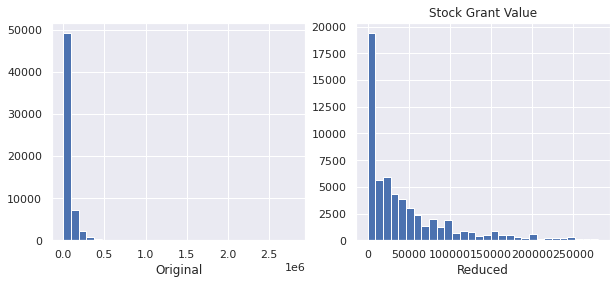

In [9]:
stock_cu = np.percentile(data.stockgrantvalue, 98)

compare_hist(data.stockgrantvalue, 'Stock Grant Value', stock_cu, 30)

In [10]:
data = data.drop(data.loc[data.stockgrantvalue > stock_cu].index)

### Potential Predictors

#### Location (cityid and dmaid) and company

The cityid and dmaid are both integer values representing the city and region, respectivly, of the job location.  The cityid has 1045 unique values, while the dmaid has 150.  Each dmaid corresponds to multiple cityids.  The correlation to totalcomp of cityids within each dmaid varies significantly.  A plot of the cityids contained in dmaid 807 is shown below to demonstrate this.  This would indicate that the cityid is likely a better predictor of the totalcomp than the dmaid.

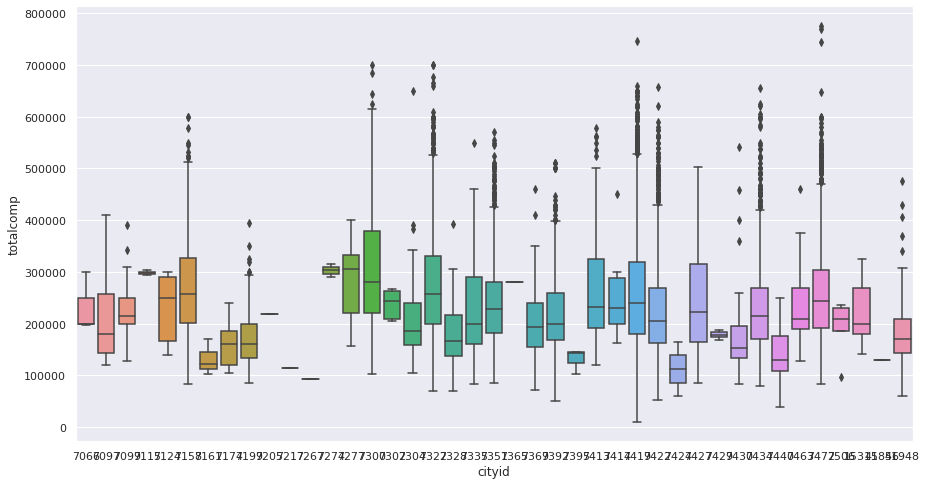

In [11]:
sns.boxplot(x='cityid', y='totalcomp', data = data[data.dmaid == 807]);

The company column contains string values with company names.  There are 1102 unique values.  Due to the substantial number of levels for the categorical variables cityid and company, it was necessary to reduce the number of levels for each to a more manageable level.  During the model phase it was determined that companies and cityids with fewer datapoints were more likely to not be statistically significant.  They demonstrated high t-values and many of their confidence intervals centered around or included zero.  This would make sense, since there would be fewer data points to train on.  For this reason, it was determined the best approach would be to remove all data points belonging to categories with the lowest number of datapoints.  The threshold used for removal was a minimum of 150 data points.  A summary of the changes to the dataset as a result is show below.

In [12]:
#data = data.astype({'cityid': 'category'})

threshold = 150
orig = data.shape[0] # original number of data points

# Remove data points & categories from cityid and company
data['city_freq'] = data.groupby('cityid')['title'].transform('count')
data = data[data.city_freq > threshold]
data['cityid'] = data.cityid.astype('category').cat.remove_unused_categories()

print('There are now ', data['cityid'].nunique(), ' levels in city')

data['company_freq'] = data.groupby('company')['title'].transform('count')
data = data[data.company_freq > threshold]
data['company'] = data.company.cat.remove_unused_categories()

print('There are company ', data['company'].nunique(), ' levels in company')

data['city_freq'] = data.groupby('cityid')['title'].transform('count')
data = data[data.city_freq > threshold].reset_index()

print('\nMinimum city frequency is ', data.city_freq.min())
print('Minimum company frequency is ', data.company_freq.min())

reduced = data.shape[0]

print('\nOriginal number of data points is ', orig)
print('Updated number of data points is ', reduced)

There are now  54  levels in city
There are company  40  levels in company

Minimum city frequency is  172
Minimum company frequency is  151.0

Original number of data points is  58538
Updated number of data points is  31257


Below is a boxplot of totalcomp vs cityids.  The wide variation in mean and variance in the data indicates the cityid is likely highly correlation to totalcomp and will be a good predictor.

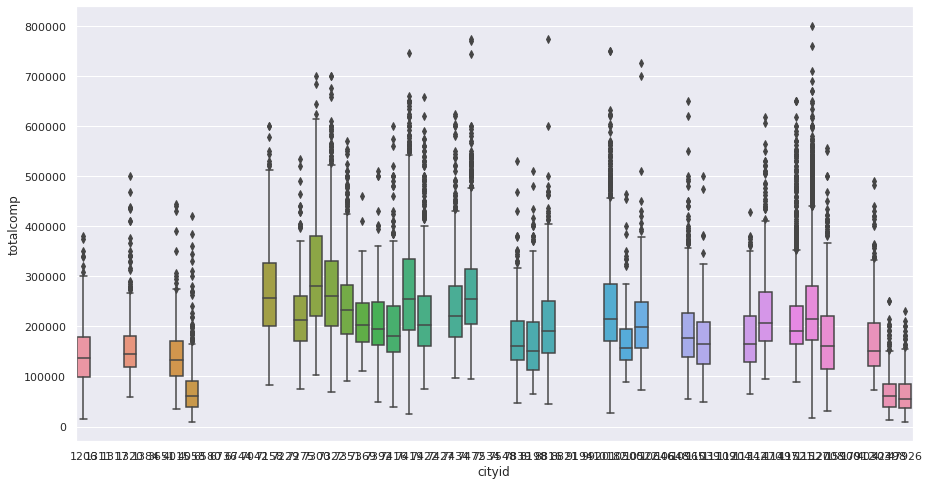

In [13]:
sns.boxplot(x='cityid', y='totalcomp', data=data);

Below is a boxplot of totalcomp vs company.  The wide variation in mean and variance in the data indicates the company is likely highly correlation to totalcomp and will be a good predictor.

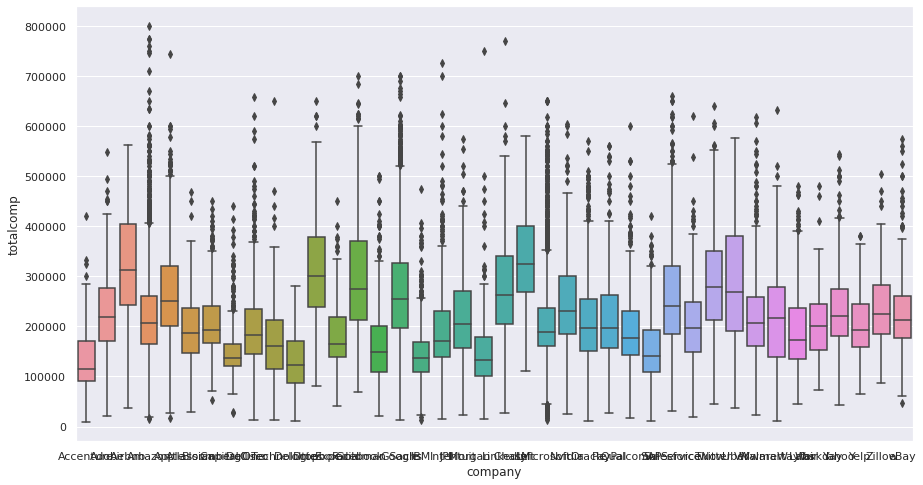

In [14]:
sns.boxplot(x='company', y='totalcomp', data=data);

An initial concern after removing a significant number of the company and cityid categories was collinearity.  This could happen if most of the cities contain only one or two companies and those companies do not have locations in other cities.  A description of the counts of each combination is provided below.  Given that there are 584 unique combinations and 75% of the combinations have fewer than 28 datapoints, collinearity is less of a concern.

In [15]:
citycompanycount = data.groupby(['cityid', 'company']).title.count()
citycompanycount = citycompanycount[citycompanycount > 0]
print(citycompanycount.describe())

count     584.000000
mean       53.522260
std       220.095144
min         1.000000
25%         2.000000
50%         8.000000
75%        28.250000
max      3822.000000
Name: title, dtype: float64


#### Experience

Below is a boxplot of totalcomp vs experience.  Overall the mean and the variance of totalcomp increases as the years of experience increases, however this trend appears to level off around 20 years and then breaks down significantly after about 25 years.  There may not be enough data points after 25 years of experience to estabilish a correlation with totalcomp in this range, as can be seen in the histogram comparison below.  The values may end up being outliers or high leverage points in the model.  However, the boxplot shows there is a postive correlation and it is likely years of experience will be a good predictor of totalcomp.

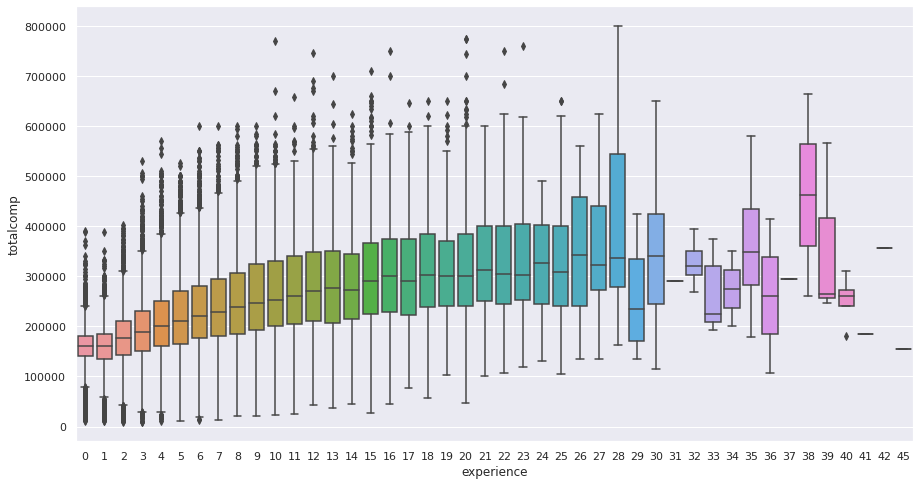

In [16]:
sns.boxplot(x='experience', y='totalcomp', data = data);

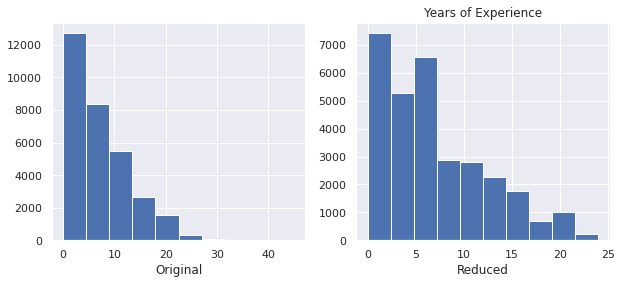

In [17]:
compare_hist(data.experience, 'Years of Experience', 25, 10)

#### Years at company

Below is a boxplot of totalcomp vs yearsatcompany.  There appears to be a slight positive correlation between the two.  As with years of experience, there are fewer data points as yearsatcompany increases, so the correlation becomes less consistent after about 15 years.  A histogram below shows the distribution of the data.  Experience and yearatcompany are related, each year worked at a company adds another year to work experience.  The correlation between these two variables is 0.515.  It is expected that experience will be a better predictor of totalcomp than yearsatcompany, but yearsatcompany may still play a role.

In [18]:
print('The correlation between experience and yearsatcompany is ', data.experience.corr(data.yearsatcompany))

The correlation between experience and yearsatcompany is  0.5149729087121881


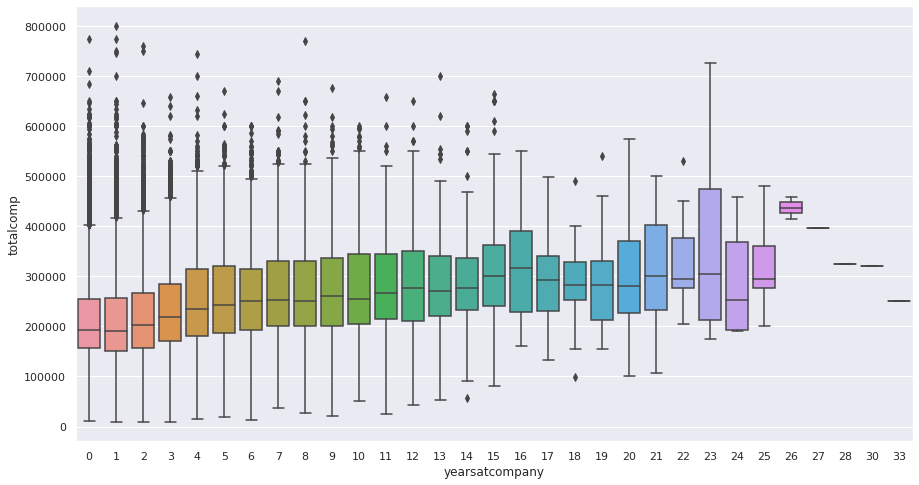

In [19]:
sns.boxplot(x='yearsatcompany', y='totalcomp', data = data);

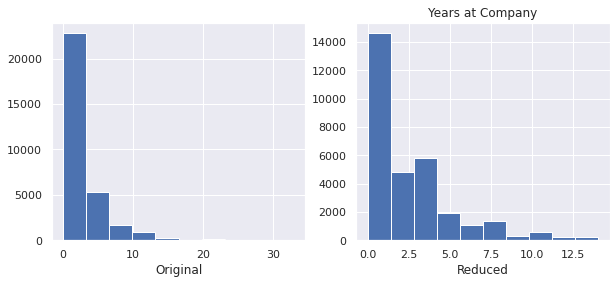

In [20]:
compare_hist(data.yearsatcompany, 'Years at Company', 15, 10)

#### Title

Below is a boxplot of totalcomp vs title.  The difference in mean values between the titles indicates there is a correlation between the title and totalcomp and it may be a good predictor.  Business Analyst, Management Consultant and Recruiter have the lowest mean values while Software Engineering Manager has the highest.

['Business Analyst', 'Data Scientist', 'Hardware Engineer', 'Human Resources', 'Management Consultant', 'Marketing', 'Mechanical Engineer', 'Product Designer', 'Product Manager', 'Recruiter', 'Sales', 'Software Engineer', 'Software Engineering Manager', 'Solution Architect', 'Technical Program Manager']


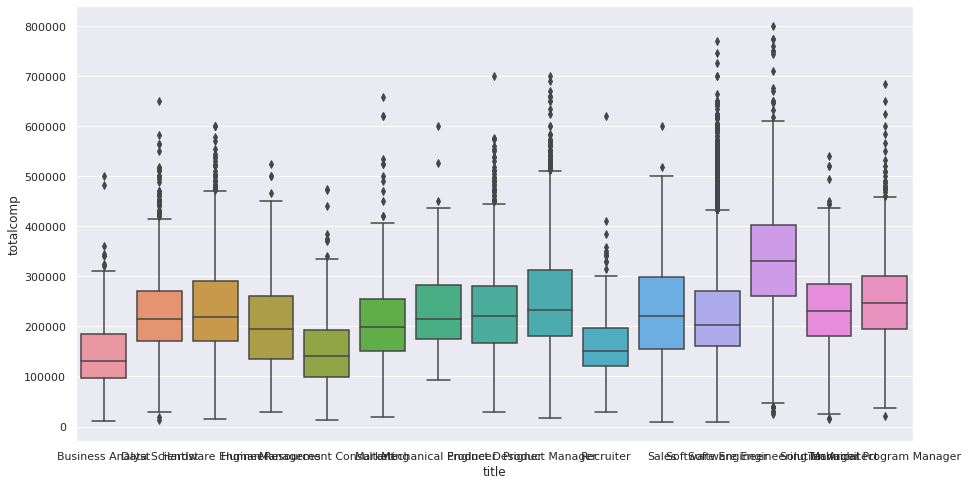

In [21]:
titles = data.title.drop_duplicates().tolist()
titles = sorted(titles)
print(titles)

sns.boxplot(x='title', y='totalcomp', data = data);

#### Gender, Education and Race

Many of the datapoints have null values for gender, education and race.  This presents a problem in using this information in the model.  A subset of the data was created named data_ger that removes all datapoints with null values and then removes cityid and company datapoints with frequencies below 150 (as was done with the original data).  A visualization of the gender, education and race is provided below.  There appears to be less of a correlation to totalcomp between these variables, as there is with other variables.  Furthermore, it is possible that these differences may be related to the other variables listed above.  For example:
 - certain companies or job titles may require a certain level of education
 - some demographics may be over or under represented in high or low paying job titles
 - changes in representation of certain groups over the last 50 years

In [22]:
print(data.shape[0])
data_ger = data.copy()
data_ger = data_ger.dropna(axis = 'rows')

orig = data_ger.shape[0] # original number of data points

# Remove data points & categories from cityid and company
data_ger['city_freq'] = data_ger.groupby('cityid')['title'].transform('count')
data_ger = data_ger[data_ger.city_freq > threshold]
data_ger['cityid'] = data_ger.cityid.astype('category').cat.remove_unused_categories()

print('There are now ', data_ger['cityid'].nunique(), ' levels in city')

data_ger['company_freq'] = data_ger.groupby('company')['title'].transform('count')
data_ger = data_ger[data_ger.company_freq > threshold]
data_ger['company'] = data_ger.company.cat.remove_unused_categories()

print('There are company ', data_ger['company'].nunique(), ' levels in company')

data_ger['city_freq'] = data_ger.groupby('cityid')['title'].transform('count')
data_ger = data_ger[data_ger.city_freq > threshold].reset_index()

print('\nMinimum city frequency is ', data_ger.city_freq.min())
print('Minimum company frequency is ', data_ger.company_freq.min())

reduced = data_ger.shape[0]

print('\nOriginal number of data points is ', orig)
print('Updated number of data points is ', reduced)

31257
There are now  18  levels in city
There are company  13  levels in company

Minimum city frequency is  156
Minimum company frequency is  153

Original number of data points is  10283
Updated number of data points is  6603


#### Gender

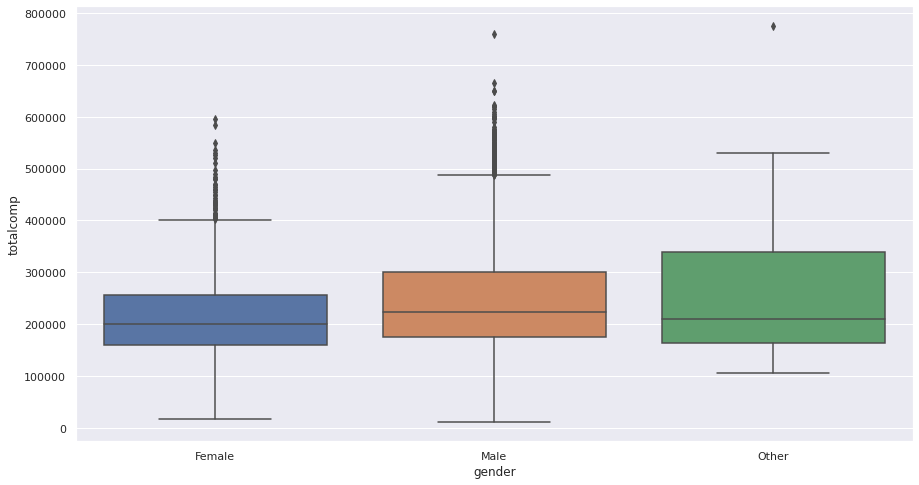

In [23]:
sns.boxplot(x='gender', y='totalcomp', data=data_ger);

#### Education

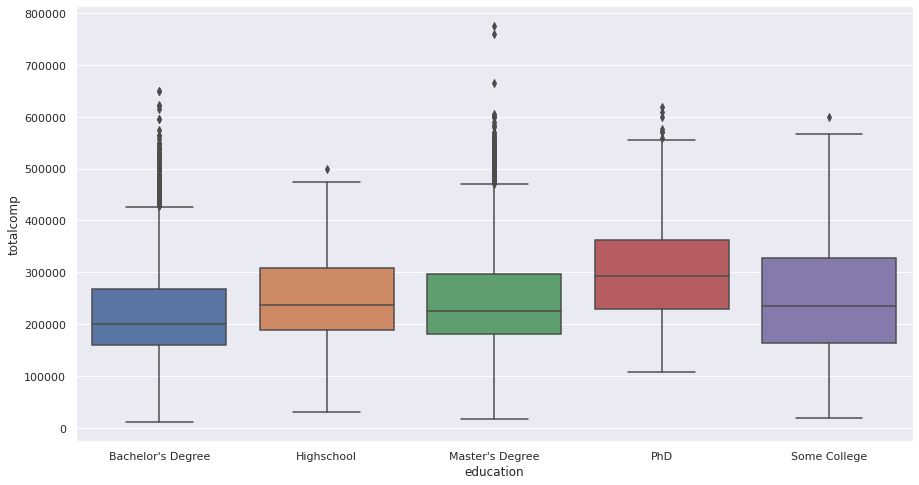

In [24]:
sns.boxplot(x='education', y='totalcomp', data=data_ger);

#### Race

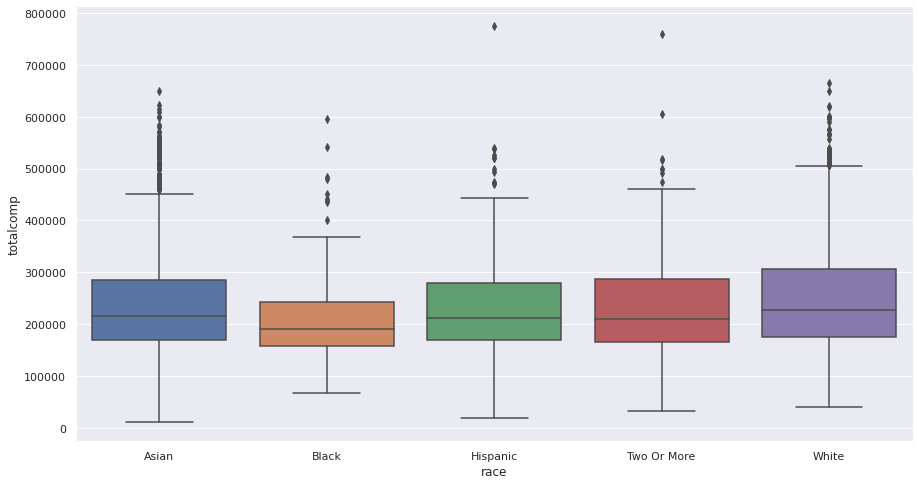

In [25]:
sns.boxplot(x='race', y='totalcomp', data=data_ger);

## Experience distribution across gender, education and race
The three histograms belows show how years of experience is destributed across gender, education and race.  This interaction likely play a role in explaining differences in totalcomp in these demographics.  There are, of course, other factors at play as well, but this just an example of potential interactions.

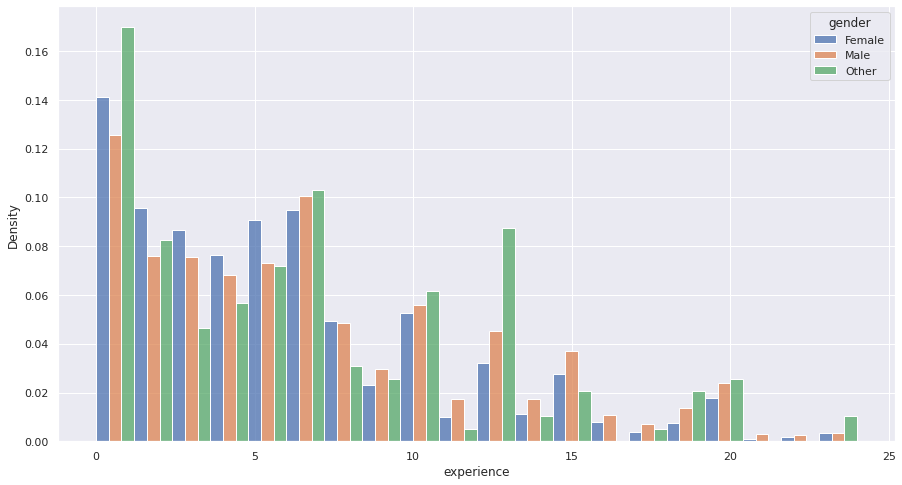

In [26]:
sns.histplot(data[data.experience < 25], x='experience', hue='gender', element='bars', bins=20, 
             multiple='dodge', stat='density', common_norm=False);

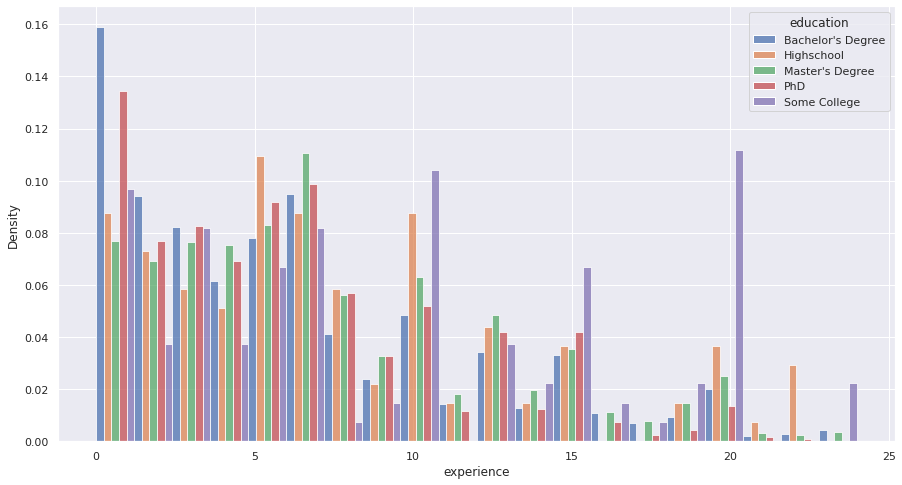

In [27]:
sns.histplot(data[data.experience < 25], x='experience', hue='education', element='bars', bins=20, 
             multiple='dodge', stat='density', common_norm=False);

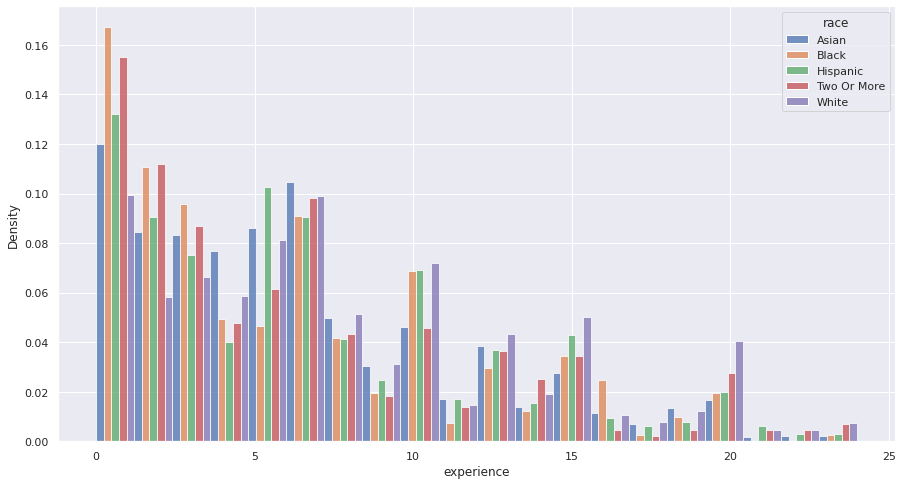

In [28]:
sns.histplot(data[data.experience < 25], x='experience', hue='race', element='bars', bins=20, 
             multiple='dodge', stat='density', common_norm=False);

## Model Selection
Multilinear regression was selected as the model approach for the following reasons:
 - there appear to be multiple variables correlated to totalcomp
 - regression allows for inferences to be drawing about whic predictors contribute most to the dependent variable
 - KNN is a poor choice for this application due to the many degress of freedom involved with the categorical variables

A best subset approach was used to identify the model with the best fit.  This was perform fits on the dataframe data.  Then it was performed again with data_ger in order to determine what role gender, education and race play in predicting totalcomp.  Summary statistics are provided below for the best fit for p=1 to p=5 for data and p=1 to p=8 for data_ger.  Best fits were determined using the R^2 values.  For each subset, interactions between the variables were also tested, but did not produce a better fit.  In most cases the p-values increases for a significant number of variable parameters.

The best subsets of p=1 to p=4 for both datasets used the same variables, indicating that cityid, experience, company and title are stronger predictors than gender, education or race.  The best subset p=5 model for the data_ger dataset included education over yearsatcompany, and the p=6 model included gender. 

The p=4 model using that dataset data was chosen from these models based because it had an R^2 value minimally less than the p=5 model, indicating the 5th variable is not significant.  This balances having a high R^2 with keeping the model simple.  

In [29]:
def model_summary(formula, df):
    model = smf.ols(formula, df).fit()
    print(model.summary().tables[0])

### data, p=1

In [30]:
model_summary('totalcomp~cityid', data)

                            OLS Regression Results                            
Dep. Variable:              totalcomp   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     297.8
Date:                Tue, 14 Dec 2021   Prob (F-statistic):               0.00
Time:                        05:37:43   Log-Likelihood:            -4.0036e+05
No. Observations:               31257   AIC:                         8.008e+05
Df Residuals:                   31225   BIC:                         8.010e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         


### data, p=2

In [31]:
model_summary('totalcomp~cityid+experience', data)

                            OLS Regression Results                            
Dep. Variable:              totalcomp   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     906.5
Date:                Tue, 14 Dec 2021   Prob (F-statistic):               0.00
Time:                        05:37:46   Log-Likelihood:            -3.9414e+05
No. Observations:               31257   AIC:                         7.883e+05
Df Residuals:                   31224   BIC:                         7.886e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         


### data, p=3

In [32]:
model_summary('totalcomp~cityid+company+experience', data)

                            OLS Regression Results                            
Dep. Variable:              totalcomp   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     565.0
Date:                Tue, 14 Dec 2021   Prob (F-statistic):               0.00
Time:                        05:37:53   Log-Likelihood:            -3.9148e+05
No. Observations:               31257   AIC:                         7.831e+05
Df Residuals:                   31185   BIC:                         7.837e+05
Df Model:                          71                                         
Covariance Type:            nonrobust                                         


### data, p=4

In [33]:
model_summary('totalcomp~cityid+company+title+experience', data)

                            OLS Regression Results                            
Dep. Variable:              totalcomp   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     544.8
Date:                Tue, 14 Dec 2021   Prob (F-statistic):               0.00
Time:                        05:38:04   Log-Likelihood:            -3.9017e+05
No. Observations:               31257   AIC:                         7.805e+05
Df Residuals:                   31171   BIC:                         7.812e+05
Df Model:                          85                                         
Covariance Type:            nonrobust                                         


### data, p=5

In [34]:
model_summary('totalcomp~cityid+company+title+experience+yearsatcompany', data)

                            OLS Regression Results                            
Dep. Variable:              totalcomp   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     541.6
Date:                Tue, 14 Dec 2021   Prob (F-statistic):               0.00
Time:                        05:38:20   Log-Likelihood:            -3.9012e+05
No. Observations:               31257   AIC:                         7.804e+05
Df Residuals:                   31170   BIC:                         7.811e+05
Df Model:                          86                                         
Covariance Type:            nonrobust                                         


### data_ger, p=1

In [35]:
model_summary('totalcomp~cityid', data_ger)

                            OLS Regression Results                            
Dep. Variable:              totalcomp   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     133.8
Date:                Tue, 14 Dec 2021   Prob (F-statistic):          9.88e-323
Time:                        05:38:21   Log-Likelihood:                -84540.
No. Observations:                6603   AIC:                         1.691e+05
Df Residuals:                    6589   BIC:                         1.692e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         


/opt/conda/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


### data_ger, p=2

In [36]:
model_summary('totalcomp~cityid+experience', data_ger)

                            OLS Regression Results                            
Dep. Variable:              totalcomp   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                     401.6
Date:                Tue, 14 Dec 2021   Prob (F-statistic):               0.00
Time:                        05:38:22   Log-Likelihood:                -83276.
No. Observations:                6603   AIC:                         1.666e+05
Df Residuals:                    6588   BIC:                         1.667e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         


/opt/conda/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


### data_ger, p=3

In [37]:
model_summary('totalcomp~cityid+company+experience', data_ger)

                            OLS Regression Results                            
Dep. Variable:              totalcomp   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     275.4
Date:                Tue, 14 Dec 2021   Prob (F-statistic):               0.00
Time:                        05:38:23   Log-Likelihood:                -82881.
No. Observations:                6603   AIC:                         1.658e+05
Df Residuals:                    6576   BIC:                         1.660e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         


### data_ger, p=4

In [38]:
model_summary('totalcomp~cityid+company+title+experience', data_ger)

                            OLS Regression Results                            
Dep. Variable:              totalcomp   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     227.6
Date:                Tue, 14 Dec 2021   Prob (F-statistic):               0.00
Time:                        05:38:24   Log-Likelihood:                -82440.
No. Observations:                6603   AIC:                         1.650e+05
Df Residuals:                    6562   BIC:                         1.652e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         


### data_ger, p=5

In [39]:
model_summary('totalcomp~cityid+company+title+experience+education', data_ger)

                            OLS Regression Results                            
Dep. Variable:              totalcomp   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     221.6
Date:                Tue, 14 Dec 2021   Prob (F-statistic):               0.00
Time:                        05:38:26   Log-Likelihood:                -82305.
No. Observations:                6603   AIC:                         1.647e+05
Df Residuals:                    6558   BIC:                         1.650e+05
Df Model:                          44                                         
Covariance Type:            nonrobust                                         


### data_ger, p=6

In [40]:
model_summary('totalcomp~cityid+company+title+experience+education+gender', data_ger)

                            OLS Regression Results                            
Dep. Variable:              totalcomp   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     214.9
Date:                Tue, 14 Dec 2021   Prob (F-statistic):               0.00
Time:                        05:38:27   Log-Likelihood:                -82277.
No. Observations:                6603   AIC:                         1.646e+05
Df Residuals:                    6556   BIC:                         1.650e+05
Df Model:                          46                                         
Covariance Type:            nonrobust                                         


### data_ger, p=7

In [41]:
model_summary('totalcomp~cityid+company+title+experience+education+gender+yearsatcompany', data_ger)

                            OLS Regression Results                            
Dep. Variable:              totalcomp   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     212.7
Date:                Tue, 14 Dec 2021   Prob (F-statistic):               0.00
Time:                        05:38:29   Log-Likelihood:                -82255.
No. Observations:                6603   AIC:                         1.646e+05
Df Residuals:                    6555   BIC:                         1.649e+05
Df Model:                          47                                         
Covariance Type:            nonrobust                                         


### data_ger, p=8

In [42]:
model_summary('totalcomp~cityid+company+title+experience+education+gender+yearsatcompany+race', data_ger)

                            OLS Regression Results                            
Dep. Variable:              totalcomp   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     196.3
Date:                Tue, 14 Dec 2021   Prob (F-statistic):               0.00
Time:                        05:38:31   Log-Likelihood:                -82251.
No. Observations:                6603   AIC:                         1.646e+05
Df Residuals:                    6551   BIC:                         1.650e+05
Df Model:                          51                                         
Covariance Type:            nonrobust                                         


### model selection: 'totalcomp~cityid+company+title+experience'



In [43]:
model = smf.ols('totalcomp~cityid+company+title+experience', data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              totalcomp   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     544.8
Date:                Tue, 14 Dec 2021   Prob (F-statistic):               0.00
Time:                        05:38:46   Log-Likelihood:            -3.9017e+05
No. Observations:               31257   AIC:                         7.805e+05
Df Residuals:                   31171   BIC:                         7.812e+05
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                             -1.609e+04   6673.282     -2.412      0.016   -2.92e+04   -3014.234
cityid[T.1311]                        -1.566e-10   3.46e-11     -4.521      0.000   -2.25e-10   -8.87e-11
cityid[T.1317]                        -9.339e-11   1.53e-11     -6.108      0.000   -1.23e-10   -6.34e-11
cityid[T.1320]                        -3041.9711   4886.616     -0.623      0.534   -1.26e+04    6535.992
cityid[T.1384]                        -4.016e-10   2.36e-11    -17.023      0.000   -4.48e-10   -3.55e-10
cityid[T.3651]                        -2.978e-10   1.85e-11    -16.087      0.000   -3.34e-10   -2.61e-10
cityid[T.4015]                        -3.259e+04   6081.699     -5.359      0.000   -4.45e+04   -2.07e+04
cityid[T.4058]                        -9.521e+04   4398.972    -21.644      0.000   -1.04e+05   -8.66e+04
cityid[T.6580]                        -1.849e-10    1.3e-11    -14.176      0.000    -2.1e-10   -1.59e-10
cityid[T.6736]                         3.907e-11    5.4e-12      7.234      0.000    2.85e-11    4.97e-11
cityid[T.6744]                        -5.104e-11   1.12e-11     -4.574      0.000   -7.29e-11   -2.92e-11
cityid[T.7042]                         7.504e-10   4.94e-11     15.188      0.000    6.54e-10    8.47e-10
cityid[T.7158]                         8.269e+04   4867.326     16.988      0.000    7.31e+04    9.22e+04
cityid[T.7229]                         2.568e-10    2.2e-11     11.684      0.000    2.14e-10       3e-10
cityid[T.7275]                         5.072e+04   5358.191      9.466      0.000    4.02e+04    6.12e+04
cityid[T.7300]                         7.036e+04   4529.255     15.535      0.000    6.15e+04    7.92e+04
cityid[T.7322]                         8.659e+04   4233.458     20.454      0.000    7.83e+04    9.49e+04
cityid[T.7351]                         8.166e+04   4670.432     17.485      0.000    7.25e+04    9.08e+04
cityid[T.7369]                         4.238e+04   9105.374      4.655      0.000    2.45e+04    6.02e+04
cityid[T.7392]                         2.388e+04   6439.958      3.708      0.000    1.13e+04    3.65e+04
cityid[T.7416]                         3.786e+04   5271.749      7.182      0.000    2.75e+04    4.82e+04
cityid[T.7419]                         7.577e+04   3903.811     19.409      0.000    6.81e+04    8.34e+04
cityid[T.7422]                         6.573e+04   4465.463     14.720      0.000     5.7e+04    7.45e+04
cityid[T.7427]                        -1.219e-10   1.31e-11     -9.319      0.000   -1.48e-10   -9.62e-11
cityid[T.7434]                         6.914e+04   4993.100     13.846      0.000    5.93e+04    7.89e+04
cityid[T.7472]                         8.041e+04   4131.385     19.464      0.000    7.23e+04    8.85e+04
cityid[T.

## Model Validation

### QQ Plot
A qq plot is shown below, showing there is a fairly linear trend in the residuals.  This validates the use of a linear regression model.

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


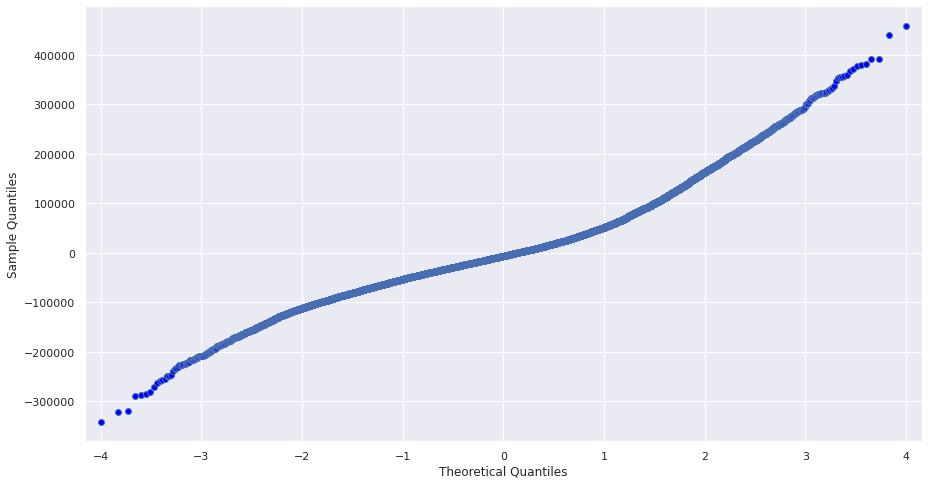

In [44]:
sm.qqplot(model.resid);

### Cross Validation
A cross validation was performed to validate the model fit.  The R^2 values of the model and the cross validated model are very similar, indicating the model fit is consistent.  The plot below shows the predicted vs measured values.  Overlap of the blue and red dots indicate the model is consistent between the training and test data.  The model predictions for totalcomp above about $350,000 is very off though.

In [45]:
y, X = patsy.dmatrices('totalcomp~cityid+company+title+experience', data=data)
lr = linear_model.LinearRegression()
predicted = cross_val_predict(lr, X, y, cv=3)
print('Model R^2 Value is: ', model.rsquared)
print('Cross Validated R^2 Values are are: ', cross_val_score(lr, X, y, cv=3))

Model R^2 Value is:  0.5976993074553594
Cross Validated R^2 Values are are:  [0.55051329 0.58810786 0.62205786]


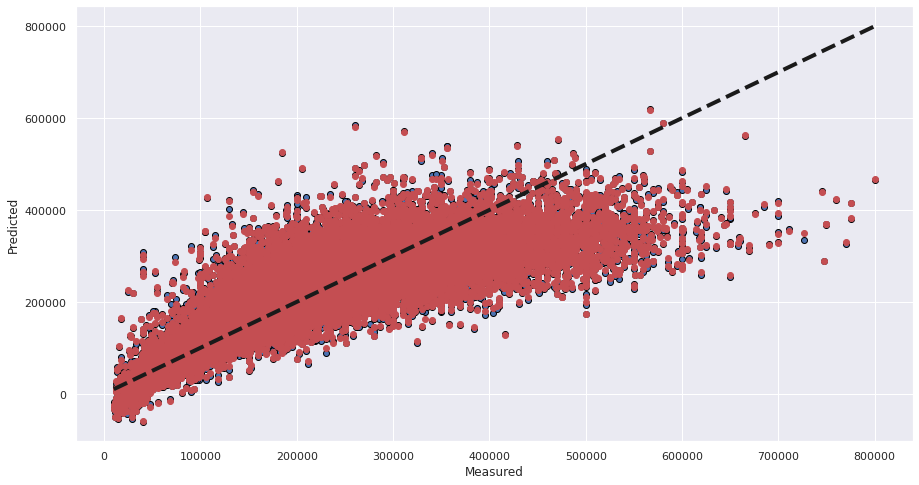

In [46]:
fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0,0,0,))
plt.plot(data.totalcomp, model.predict(data), 'ro')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted');

## Model Refinement

### Leverage Plot
The leverage plot below shows there are a number of high leverage and high residual datapoints.  An iterative process was used to remove these datapoints and re-trian the model.

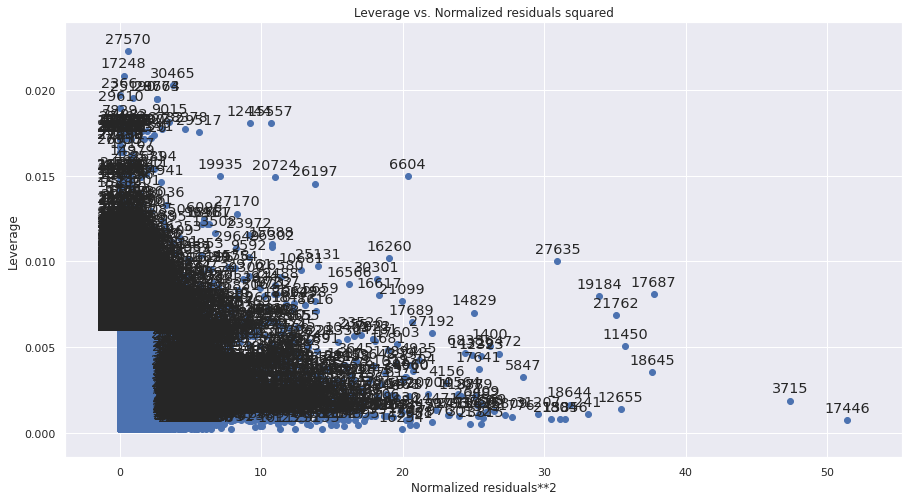

In [47]:
sm.graphics.plot_leverage_resid2(model, alpha=0.05);

In [48]:
def refinement(df, model, l, r):
    df['leverage'] = model.get_influence().hat_matrix_diag
    df['residualsquared'] = (model.get_influence().resid_studentized_internal)**2
    df = df[df.leverage < np.percentile(df.leverage, l)]
    df = df[df.residualsquared < np.percentile(df.residualsquared, r)]
    return df

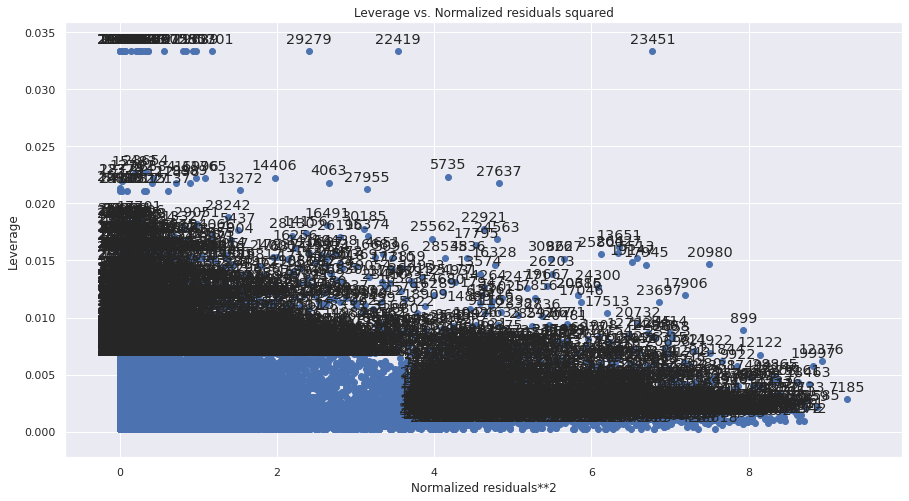

In [49]:
data_refined = data.copy()
data_refined = refinement(data_refined, model, 95, 95)
model_refined = smf.ols('totalcomp~cityid+company+title+experience', data_refined).fit()
sm.graphics.plot_leverage_resid2(model_refined, alpha=0.05);

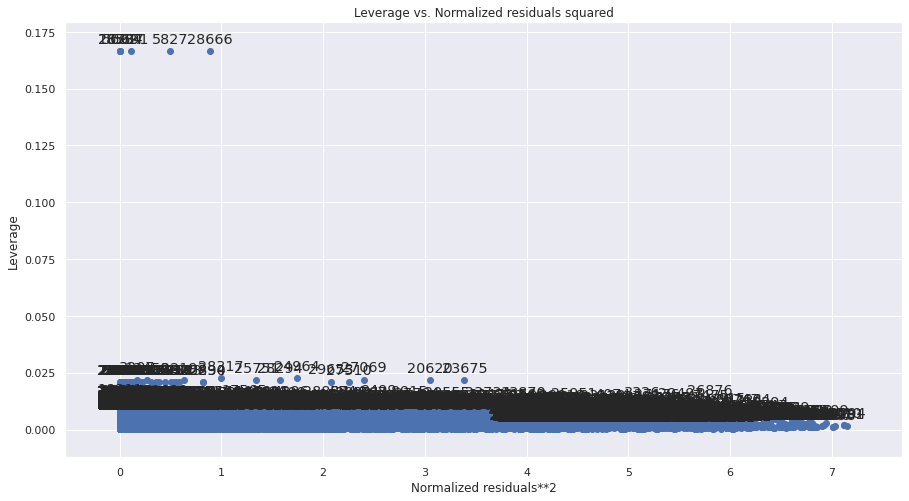

In [50]:
data_refined = refinement(data_refined, model_refined, 95, 95)
model_refined = smf.ols('totalcomp~cityid+company+title+experience', data_refined).fit()
sm.graphics.plot_leverage_resid2(model_refined, alpha=0.05);

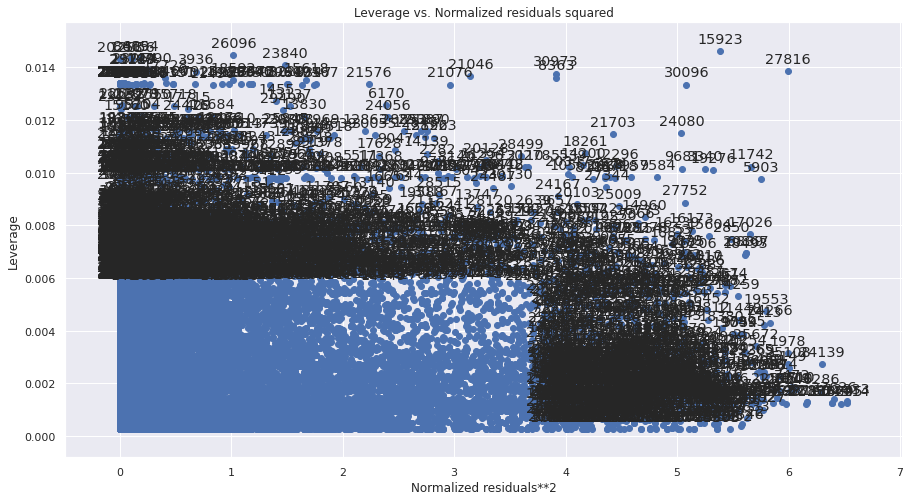

In [51]:
data_refined = refinement(data_refined, model_refined, 95, 95)
model_refined = smf.ols('totalcomp~cityid+company+title+experience', data_refined).fit()
sm.graphics.plot_leverage_resid2(model_refined, alpha=0.05);

## Final Model

A summary of the final model is shown below.  Refinement improved the R^2 value and improved the p-values associate with a number of model parameters.  It also removed all datapoints from several company and job title categories, reducing the degrees of freedom in the model.  An updated cross-validation plot of the measured vs predicted is also shown below.  The updated model does a much better job of predicting total company above $350,000.

In [52]:
model_refined.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              totalcomp   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     1132.
Date:                Tue, 14 Dec 2021   Prob (F-statistic):               0.00
Time:                        05:41:37   Log-Likelihood:            -2.7447e+05
No. Observations:               22974   AIC:                         5.491e+05
Df Residuals:                   22909   BIC:                         5.496e+05
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                              4.886e+04   3857.264     12.666      0.000    4.13e+04    5.64e+04
cityid[T.1311]                        -3.344e-10   1.93e-11    -17.328      0.000   -3.72e-10   -2.97e-10
cityid[T.1317]                        -2.695e-11   1.51e-12    -17.841      0.000   -2.99e-11    -2.4e-11
cityid[T.1320]                        -5885.8123   3658.409     -1.609      0.108   -1.31e+04    1284.917
cityid[T.1384]                        -1.762e-10   1.42e-11    -12.371      0.000   -2.04e-10   -1.48e-10
cityid[T.3651]                        -1.161e-10   7.73e-12    -15.030      0.000   -1.31e-10   -1.01e-10
cityid[T.4015]                        -2.999e-11   5.09e-12     -5.895      0.000      -4e-11      -2e-11
cityid[T.4058]                        -9.669e+04   3428.259    -28.204      0.000   -1.03e+05      -9e+04
cityid[T.6580]                         -3.66e-11    4.4e-12     -8.321      0.000   -4.52e-11    -2.8e-11
cityid[T.6736]                        -1.296e-10   1.32e-11     -9.836      0.000   -1.55e-10   -1.04e-10
cityid[T.6744]                        -3.575e-11   3.73e-12     -9.571      0.000   -4.31e-11   -2.84e-11
cityid[T.7042]                         8.343e-11    5.3e-12     15.756      0.000    7.31e-11    9.38e-11
cityid[T.7158]                         6.897e+04   3750.645     18.389      0.000    6.16e+04    7.63e+04
cityid[T.7229]                         -4.35e-11   3.29e-12    -13.228      0.000   -4.99e-11   -3.71e-11
cityid[T.7275]                         4.473e+04   4774.702      9.369      0.000    3.54e+04    5.41e+04
cityid[T.7300]                         5.402e+04   3558.488     15.180      0.000     4.7e+04     6.1e+04
cityid[T.7322]                         7.371e+04   3374.710     21.841      0.000    6.71e+04    8.03e+04
cityid[T.7351]                         7.152e+04   3649.333     19.597      0.000    6.44e+04    7.87e+04
cityid[T.7369]                         2.208e+04   2164.106     10.204      0.000    1.78e+04    2.63e+04
cityid[T.7392]                         -3.15e-11   3.74e-12     -8.412      0.000   -3.88e-11   -2.42e-11
cityid[T.7416]                          4.05e+04   4451.004      9.099      0.000    3.18e+04    4.92e+04
cityid[T.7419]                         6.749e+04   3198.247     21.102      0.000    6.12e+04    7.38e+04
cityid[T.7422]                         5.632e+04   3543.457     15.894      0.000    4.94e+04    6.33e+04
cityid[T.7427]                        -3.669e-11   3.02e-12    -12.145      0.000   -4.26e-11   -3.08e-11
cityid[T.7434]                          5.89e+04   4320.922     13.631      0.000    5.04e+04    6.74e+04
cityid[T.7472]                         6.979e+04   3290.792     21.207      0.000    6.33e+04    7.62e+04
cityid[T.

In [53]:
y, X = patsy.dmatrices('totalcomp~cityid+company+title+experience', data=data_refined)
lr = linear_model.LinearRegression()
predicted = cross_val_predict(lr, X, y, cv=3)
print('Model R^2 Value is: ', model_refined.rsquared)
print('Cross Validated R^2 Values are are: ', cross_val_score(lr, X, y, cv=3))

Model R^2 Value is:  0.7597855589846922
Cross Validated R^2 Values are are:  [0.71906593 0.75835298 0.77844929]


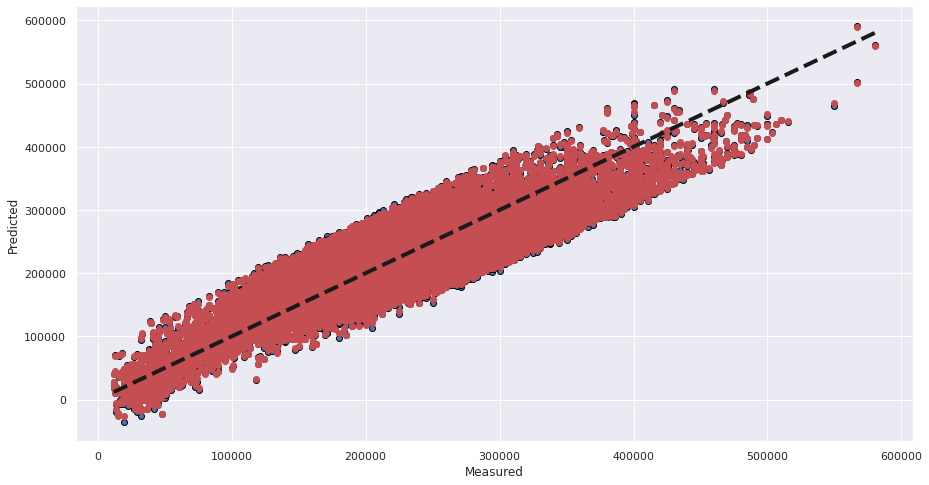

In [54]:

fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0,0,0,))
plt.plot(data_refined.totalcomp, model_refined.predict(data_refined), 'ro')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted');

## Conclusion
There are many factors involved in an employees compensation.  The model demonstrated that major factors contributing to increased wages are job location, years of experience, company and job title.  A linear regression model was fit to these four variables and cross validation demonstrated the model was consistent between training and test data.  Leverage plots were used to identify outliers and further improve the model.  This removed several parameters and improved the statistical significance of others.

### Potential Model Improvements
A major factor the model failed to take into account is the difference in cost of living in differenct cities.  The model would be more meaninful if the totalcomp were adjusted based on the cities cost of living.  Most cities with high wages also have a higher cost of living, so it would be interesting to see how this changes the predictive value of jobs location.  Likely, location would no longer be the biggest factor.